#### Saturday, February 24, 2024

Let's try to conduct a search for images of a specific person on the Match images.

OK. Nice! Got this to work! Great!

In [1]:
import cv2
import numpy
import time
import csv
from glob import glob
from pathlib import Path
from statistics import mean

from towhee import pipe, ops, DataCollection
from towhee.types.image import Image
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

/home/rob/miniforge3/envs/milvus/lib/python3.11/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


First thing we need to do is to build a list of all the images in our MyMatchImages dataset.

In [2]:
MY_MATCH_IMAGES_ROOT_FOLDER = '/home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images'

Create a function to scan the folder and return the list of files.

In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image

def scan_images(folder_path):
    image_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):

                fullFileName = os.path.join(root, file)
                rootFile = fullFileName.replace(folder_path+"/","")
                userId = rootFile.replace("/"+ file,"")
                
                # obtain the image properties
                img = Image.open(fullFileName)
                width, height = img.size
                format_type = img.format
                mode = img.mode
                img.close()

                image_files.append([fullFileName, userId, rootFile, file, width, height, format_type, mode])
                
    return image_files

Now scan the target folder, building the list of files to be uploaded.

In [4]:
my_match_images = scan_images(MY_MATCH_IMAGES_ROOT_FOLDER)
len(my_match_images)

# 7.0 s

19651

In [5]:
my_match_images[42]

['/home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/mzMSydVu3xfI_soFv4UliA2/af1eb47f-0d1d-ee11-9101-f40343f49558.jpeg',
 'mzMSydVu3xfI_soFv4UliA2',
 'mzMSydVu3xfI_soFv4UliA2/af1eb47f-0d1d-ee11-9101-f40343f49558.jpeg',
 'af1eb47f-0d1d-ee11-9101-f40343f49558.jpeg',
 900,
 1000,
 'JPEG',
 'RGB']

Create a pandas dataframe of the data, then save that dataframe as a csv file.

In [6]:
column_names = ['Full_File_Name', 'User_Id', 'Root_File_Name', 'File_Name', 'Image_Width', 'Image_Height', 'Image_Format', 'Image_Mode']

In [7]:
dfMyMatchImages = pd.DataFrame(my_match_images, columns=column_names)

In [8]:
dfMyMatchImages.head(10)

,Full_File_Name,User_Id,Root_File_Name,File_Name,Image_Width,Image_Height,Image_Format,Image_Mode
0,/home/rob/Data/Documents/Github/rkaunismaa/NLP...,zwuhN2JsKCYu_bHIYadOig2,zwuhN2JsKCYu_bHIYadOig2/3ceb7bf7-c70f-ee11-910...,3ceb7bf7-c70f-ee11-9101-f40343f42de0.jpeg,1000,1000,JPEG,RGB
1,/home/rob/Data/Documents/Github/rkaunismaa/NLP...,zwuhN2JsKCYu_bHIYadOig2,zwuhN2JsKCYu_bHIYadOig2/6baa1d11-c80f-ee11-910...,6baa1d11-c80f-ee11-9101-f40343f42de0.jpeg,712,711,JPEG,RGB
2,/home/rob/Data/Documents/Github/rkaunismaa/NLP...,zwuhN2JsKCYu_bHIYadOig2,zwuhN2JsKCYu_bHIYadOig2/a71566ad-c80f-ee11-910...,a71566ad-c80f-ee11-9101-f40343f42de0.jpeg,772,771,JPEG,RGB
3,/home/rob/Data/Documents/Github/rkaunismaa/NLP...,zwuhN2JsKCYu_bHIYadOig2,zwuhN2JsKCYu_bHIYadOig2/4da52ed3-c70f-ee11-910...,4da52ed3-c70f-ee11-9101-f40343f42de0.jpeg,999,1000,JPEG,RGB
4,/home/rob/Data/Documents/Github/rkaunismaa/NLP...,zwuhN2JsKCYu_bHIYadOig2,zwuhN2JsKCYu_bHIYadOig2/1fc57056-c80f-ee11-910...,1fc57056-c80f-ee11-9101-f40343f42de0.jpeg,804,804,JPEG,RGB
5,/home/rob/Data/Documents/Github/rkaunismaa/NLP...,zwuhN2JsKCYu_bHIYadOig2,zwuhN2JsKCYu_bHIYadOig2/24cd1b6b-c90f-ee11-910...,24cd1b6b-c90f-ee11-9101-f40343f42de0.jpeg,994,994,JPEG,RGB
6,/home/rob/Data/Documents/Github/rkaunismaa/NLP...,pzkZAx4sfVx5wJv2ilt4Ew2,pzkZAx4sfVx5wJv2ilt4Ew2/60e48b54-b778-ee11-910...,60e48b54-b778-ee11-910c-f40343f4ab48.jpeg,820,1000,JPEG,RGB
7,/home/rob/Data/Documents/Github/rkaunismaa/NLP...,tELk2_nzXAh2XJa_SNSuTw2,tELk2_nzXAh2XJa_SNSuTw2/e983b8f2-71a2-ed11-90f...,e983b8f2-71a2-ed11-90fd-f40343f49558.jpeg,750,1000,JPEG,RGB
8,/home/rob/Data/Documents/Github/rkaunismaa/NLP...,tELk2_nzXAh2XJa_SNSuTw2,tELk2_nzXAh2XJa_SNSuTw2/f283b8f2-71a2-ed11-90f...,f283b8f2-71a2-ed11-90fd-f40343f49558.jpeg,750,1000,JPEG,RGB
9,/home/rob/Data/Documents/Github/rkaunismaa/NLP...,tELk2_nzXAh2XJa_SNSuTw2,tELk2_nzXAh2XJa_SNSuTw2/26100f9c-31a2-ed11-90f...,26100f9c-31a2-ed11-90fd-f40343f49558.jpeg,480,640,JPEG,RGB


Now save that dataframe to a csv file.

In [9]:
my_match_images_csv_filename = "MyMatchImages.csv"
dfMyMatchImages.to_csv(my_match_images_csv_filename)

Next, let's create the embeddings for these images.

In [10]:
MODEL = 'resnet50'
DEVICE = 'cuda' # if None, use default device (cuda is enabled if available)

# Milvus parameters
HOST = '127.0.0.1'
PORT = '19530'
TOPK = 10
DIM = 2048 # dimension of embedding extracted by MODEL
COLLECTION_NAME = 'My_Match_Images'
INDEX_TYPE = 'IVF_FLAT'
METRIC_TYPE = 'L2'

# path to csv (column_1 indicates image path) OR a pattern of image paths
INSERT_SRC = my_match_images_csv_filename

# target match query search image
someMatchImage = 'zzzz_Test/df2d5f53-5683-ed11-90fd-f40343f49558.jpeg'
someMatchImage = 'zzzz_Test/*.jpeg'
QUERY_SRC = MY_MATCH_IMAGES_ROOT_FOLDER + "/" + someMatchImage

In [11]:
QUERY_SRC

'/home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/zzzz_Test/*.jpeg'

In [12]:
! ls /home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/zzzz__Test/df2d5f53-5683-ed11-90fd-f40343f49558.jpeg

/home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/zzzz__Test/df2d5f53-5683-ed11-90fd-f40343f49558.jpeg


In [13]:
# Load image path
def load_image(x):
    if x.endswith('csv'):
        with open(x) as f:
            reader = csv.reader(f)
            next(reader)
            for item in reader:
                yield item[1]
    else:
        for item in glob(x):
            yield item
            

In [14]:
# Embedding pipeline
p_embed = (
    pipe.input('src')
        .flat_map('src', 'img_path', load_image)
        .map('img_path', 'img', ops.image_decode())
        .map('img', 'vec', ops.image_embedding.timm(model_name=MODEL, device=DEVICE))
)

In [15]:
# Display embedding result, no need for implementation
p_display = p_embed.output('img_path', 'img', 'vec')

In [17]:
my_search_image = "/home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/zzzz__Test/df2d5f53-5683-ed11-90fd-f40343f49558.jpeg"

img_path,img,vec
/home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/zzzz__Test/df2d5f53-5683-ed11-90fd-f4034...,,"[0.0, 0.06739511, 0.00029005748, ...] shape=(2048,)"

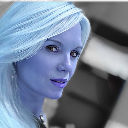

<Figure size 128x128 with 0 Axes>

In [18]:
DataCollection(p_display(my_search_image)).show()

In [19]:
# Create milvus collection (delete first if exists)
def create_milvus_collection(collection_name, dim):
    
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
        FieldSchema(name='path', dtype=DataType.VARCHAR, description='path to image', max_length=500, 
                    is_primary=True, auto_id=False),
        FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, description='image embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='reverse image search')
    collection = Collection(name=collection_name, schema=schema)

    index_params = {
        'metric_type': METRIC_TYPE,
        'index_type': INDEX_TYPE,
        'params': {"nlist": 2048}
    }
    collection.create_index(field_name='embedding', index_params=index_params)
    return collection

In [20]:
# Connect to Milvus service
connections.connect(host=HOST, port=PORT)

In [21]:
# Create collection
collection = create_milvus_collection(COLLECTION_NAME, DIM)
print(f'A new collection created: {COLLECTION_NAME}')

A new collection created: My_Match_Images


In [22]:
# I had to add this line myself ... 
collection.load()

In [23]:
# Insert pipeline
p_insert = (
        p_embed.map(('img_path', 'vec'), 'mr', ops.ann_insert.milvus_client(
                    host=HOST,
                    port=PORT,
                    collection_name=COLLECTION_NAME
                    ))
          .output('mr')
)

In [24]:
# Insert data
# This is putting a 100% load on all 8 CPU's ... why is it not using the GPU??
p_insert(INSERT_SRC)

# 8m 57.3s

In [25]:
# Wow ... I also had to add this here to make 'collection.num_entities' show the correct number ... 
collection.flush()

In [26]:
# Check collection
print('Number of data inserted:', collection.num_entities)

Number of data inserted: 19651


In [27]:
# Search pipeline
p_search_pre = (
        p_embed.map('vec', ('search_res'), ops.ann_search.milvus_client(
                    host=HOST, port=PORT, limit=TOPK,
                    collection_name=COLLECTION_NAME))
               .map('search_res', 'pred', lambda x: [str(Path(y[0]).resolve()) for y in x])
#                .output('img_path', 'pred')
)


In [28]:
p_search = p_search_pre.output('img_path', 'pred')

In [29]:
# Search for example query image(s)
collection.load()
dc = p_search('../../../NLP4HTML/express/express-match/public/images/zzzz__Test/*.jpeg')

# Display search results with image paths
DataCollection(dc).show()

img_path,pred
../../../NLP4HTML/express/express-match/public/images/zzzz__Test/df2d5f53-5683-ed11-90fd-f40343f49558.jpeg,/home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/ko1yxtyDnBYUnshNvpaiAw2/df2d5f53-5683-ed... /home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/zzzz__Test/df2d5f53-5683-ed11-90fd-f4034... /home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/SomeMadeUpFolder/df2d5f53-5683-ed11-90fd... /home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/VrKhTeiDVI07zFDxk9YqlA2/4afd00a0-241d-ee... /home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/NSEZXOMVFV3y5BhdK3LGkA2/de72f2e9-e9c9-ed... /home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/QsGLNH9vDMf1J4QY_5TIsA2/78ab7c18-315b-ee... /home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/hxIodP_aktIqOO3hPidYmw2/f55334ac-b2bd-ed... /home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/nPxbzH_3Jjgfpg0TMSHrtg2/60a43b4a-f493-ee... /home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/G17lDlcN2KTNI5omW6FqEw2/37e6bc2a-b797-ee... /home/rob/Data/Documents/Github/rkaunismaa/NLP4HTML/express/express-match/public/images/VTQv9Sb2OmgLw2_DJyNS-g2/cc2edd7f-09ab-ee...


In [30]:
# Display search results with images, no need for implementation

import cv2
from towhee.types.image import Image

def read_images(img_paths):
    imgs = []
    for p in img_paths:
        imgs.append(Image(cv2.imread(p), 'BGR'))
    return imgs

p_search_img = (
    p_search_pre.map('pred', 'pred_images', read_images)
                .output('img', 'pred_images')
)

img,pred_images
,

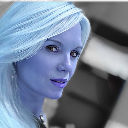
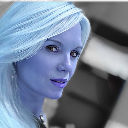
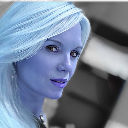
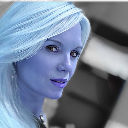
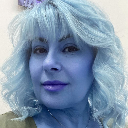
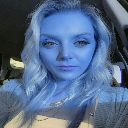
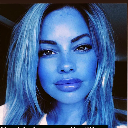
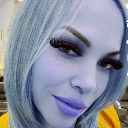
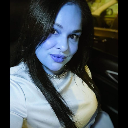
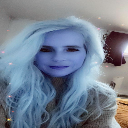
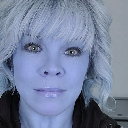

In [31]:
DataCollection(p_search_img('../../../NLP4HTML/express/express-match/public/images/zzzz__Test/*.jpeg')).show()